### 👨‍💻 Student Details

**Name:** Somasekhara S  
**Register Number:** 23011101124  
**Batch:** AIDS - B (Batch 2)


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### 🧠 Introduction and Dataset Description

This project focuses on developing a **Binary Video Classification System** that automatically identifies whether a given video depicts **Violence** or **Non-Violence**.  
The objective is to leverage **Convolutional Neural Networks (CNNs)** to learn visual patterns that can differentiate between aggressive and peaceful human actions.

**Dataset Overview:**  
We use the *Real-Life Violence and Non-Violence Dataset* sourced from Kaggle.  
The dataset contains short video clips that have been decomposed into frames and divided into two primary categories:
- 🟥 **Violence** — frames that capture fights, aggressive motion, or physical conflict.  
- 🟩 **Non-Violence** — frames showing calm or normal activities without violence.  

Each video is represented by multiple frames, allowing the CNN to analyze spatial features such as body posture, motion blur, and environmental context within each frame.  
This dataset provides a balanced and realistic benchmark for testing violence detection models in real-world conditions.

**Goal:**  
The study aims to train and evaluate three CNN-based architectures:  
- A **Custom CNN** built from scratch.  
- A **ResNet50** model using transfer learning.  
- A **MobileNetV2** model for lightweight, efficient inference.  

Through comparative evaluation, we assess the trade-off between accuracy, computational efficiency, and generalization, ultimately identifying the best architecture for real-time violence detection.


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("karandeep98/real-life-violence-and-nonviolence-data")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/real-life-violence-and-nonviolence-data


In [3]:
import os, cv2, time, numpy as np, matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess

DATA_DIR = "/kaggle/input/real-life-violence-and-nonviolence-data/violence_dataset"
print("✅ Dataset Path:", DATA_DIR)
print("Subfolders:", os.listdir(DATA_DIR))


2025-10-17 16:21:17.893367: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760718078.139803      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760718078.207676      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ Dataset Path: /kaggle/input/real-life-violence-and-nonviolence-data/violence_dataset
Subfolders: ['non_violence', 'violence']


### 🧹 Data Preprocessing and Visualization

Before training our CNN models, each image frame undergoes preprocessing to improve feature quality and visual consistency across samples.  
The main goal is to enhance contrast, normalize brightness, and ensure uniform input size for all models.

**Preprocessing steps include:**
- 🎨 **Color Conversion:** Convert frames from BGR to RGB for correct color representation.  
- 🌈 **Brightness & Contrast Adjustment:** Slightly increase contrast and brightness using linear scaling.  
- ⚡ **CLAHE (Contrast Limited Adaptive Histogram Equalization):** Improves visibility of fine details under variable lighting.  
- 📏 **Resizing:** All frames are resized to **224×224 pixels** to match the input shape of ResNet50 and MobileNetV2.  
- 🔄 **Normalization:** Pixel values are scaled to the range [0, 1] for stable gradient flow during training.

The following figure visualizes a few sample frames from both the **Violence** and **Non-Violence** categories before and after preprocessing.  
Notice the enhanced clarity and consistent lighting in the processed images, which helps the CNN learn sharper features during training.


Images used for visualization:
NV_1.mp4_frame0.jpg
NV_1.mp4_frame1.jpg
NV_1.mp4_frame2.jpg
V_1.mp4_frame0.jpg
V_1.mp4_frame1.jpg
V_1.mp4_frame2.jpg


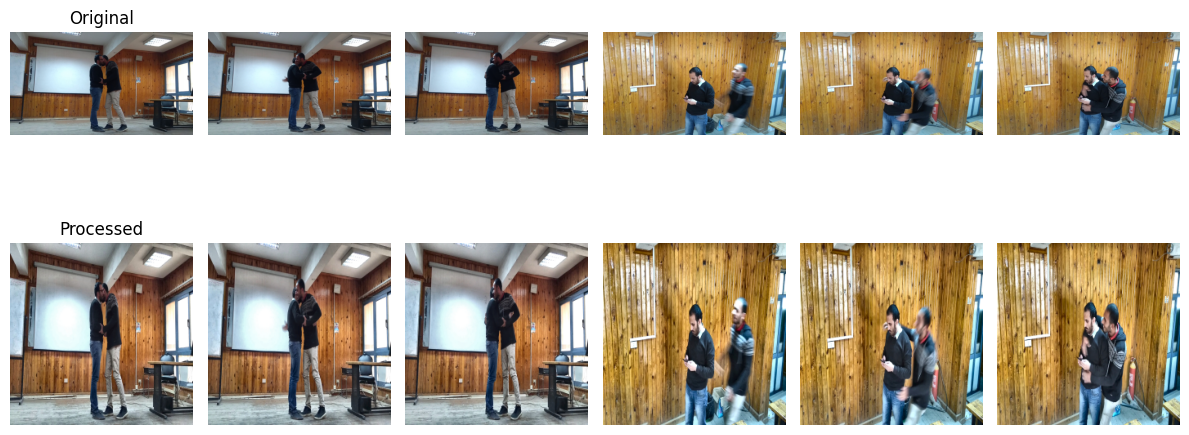

In [5]:

# 🧹 Preprocessing Function

def preprocess_image(img, size=(224, 224)):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.convertScaleAbs(img, alpha=1.1, beta=10)
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l = clahe.apply(l)
    img = cv2.cvtColor(cv2.merge((l, a, b)), cv2.COLOR_LAB2RGB)
    img = cv2.resize(img, size, interpolation=cv2.INTER_AREA)
    return img.astype("float32") / 255.0


# 🖼️ Visualize Original vs Processed Images from Dataset


non_violence_dir = os.path.join(DATA_DIR, "non_violence")
violence_dir = os.path.join(DATA_DIR, "violence")

# Pick first 3 valid .jpg files from each class
non_violence_imgs = sorted([f for f in os.listdir(non_violence_dir) if f.endswith('.jpg')])[:3]
violence_imgs = sorted([f for f in os.listdir(violence_dir) if f.endswith('.jpg')])[:3]

sample_paths = [os.path.join(non_violence_dir, f) for f in non_violence_imgs] + \
                [os.path.join(violence_dir, f) for f in violence_imgs]

print("Images used for visualization:")
for f in sample_paths:
    print(os.path.basename(f))

plt.figure(figsize=(12,6))
for i, path in enumerate(sample_paths):
    img = cv2.imread(path)
    proc = preprocess_image(img)

    # Original
    plt.subplot(2, len(sample_paths), i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    if i == 0:
        plt.title("Original")

    # Processed
    plt.subplot(2, len(sample_paths), i+1+len(sample_paths))
    plt.imshow(proc)
    plt.axis('off')
    if i == 0:
        plt.title("Processed")

plt.tight_layout()
plt.show()


### 🧩 Data Loading and Augmentation

To train the CNN models effectively, we use the **ImageDataGenerator** class from TensorFlow Keras to preprocess and augment image data directly from the dataset folders.  
Each model uses a separate generator to ensure that its preprocessing aligns with its expected input format.

**Key points:**
- 🔹 **Custom CNN** uses `rescale=1./255` to normalize pixel values between 0 and 1.  
- 🔹 **ResNet50** uses the built-in `resnet_preprocess` function (ImageNet mean–std normalization).  
- 🔹 **MobileNetV2** uses `mobilenet_preprocess`, which scales images to the range [–1, 1].  
- 🔹 All generators include an **80 : 20 train–validation split**.  
- 🔹 Lightweight **data augmentation** (rotation, zoom, and horizontal flip) helps the models generalize to unseen data.  

This step prepares the dataset so that each network receives images in the exact format it was designed for, preventing feature-scale mismatches and improving overall training stability.


In [6]:
# Custom CNN Generator
cnn_gen = ImageDataGenerator(rescale=1./255, rotation_range=10, zoom_range=0.1,
                             horizontal_flip=True, validation_split=0.2)
cnn_train = cnn_gen.flow_from_directory(DATA_DIR, target_size=(224,224),
                                        batch_size=32, class_mode='binary', subset='training')
cnn_val = cnn_gen.flow_from_directory(DATA_DIR, target_size=(224,224),
                                      batch_size=32, class_mode='binary', subset='validation')

# ResNet50 Generator
resnet_gen = ImageDataGenerator(preprocessing_function=resnet_preprocess, validation_split=0.2)
resnet_train = resnet_gen.flow_from_directory(DATA_DIR, target_size=(224,224),
                                              batch_size=32, class_mode='binary', subset='training')
resnet_val = resnet_gen.flow_from_directory(DATA_DIR, target_size=(224,224),
                                            batch_size=32, class_mode='binary', subset='validation')

# MobileNetV2 Generator
mobilenet_gen = ImageDataGenerator(preprocessing_function=mobilenet_preprocess, validation_split=0.2)
mobilenet_train = mobilenet_gen.flow_from_directory(DATA_DIR, target_size=(224,224),
                                                    batch_size=32, class_mode='binary', subset='training')
mobilenet_val = mobilenet_gen.flow_from_directory(DATA_DIR, target_size=(224,224),
                                                  batch_size=32, class_mode='binary', subset='validation')


Found 8851 images belonging to 2 classes.
Found 2212 images belonging to 2 classes.
Found 8851 images belonging to 2 classes.
Found 2212 images belonging to 2 classes.
Found 8851 images belonging to 2 classes.
Found 2212 images belonging to 2 classes.


### ⚙️ Callbacks and Training Visualization

To improve model training efficiency and avoid overfitting, two key **callbacks** are used during training:

- 🧠 **ModelCheckpoint:** Automatically saves the model with the best validation accuracy, ensuring that only the most optimal weights are preserved.  
- 🕒 **EarlyStopping:** Monitors validation loss and stops training when improvement plateaus, restoring the best weights observed during training.  

In addition, the **`plot_history()`** function visualizes training progress for each model by plotting:
- 📈 **Accuracy curves** for training and validation data.  
- 📉 **Loss curves** to track convergence behavior and detect overfitting.

These visual tools make it easier to evaluate how well each model learns and generalizes during the training process.


In [7]:
def get_callbacks(name):
    return [
        ModelCheckpoint(f"{name}_best.h5", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1),
        EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1)
    ]

def plot_history(hist, title=""):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.plot(hist.history['accuracy'], label='Train'); plt.plot(hist.history['val_accuracy'], label='Val')
    plt.title(f"{title} Accuracy"); plt.legend()
    plt.subplot(1,2,2); plt.plot(hist.history['loss'], label='Train'); plt.plot(hist.history['val_loss'], label='Val')
    plt.title(f"{title} Loss"); plt.legend(); plt.show()


### 🧱 Custom CNN – Model Design and Implementation

The **Custom CNN** serves as a baseline deep learning model designed to learn both **spatial** and simplified **temporal** cues by processing groups of consecutive video frames.  
Each video is represented by multiple sampled frames that are aggregated into a single tensor before training, allowing the network to analyze subtle motion-based differences between frames.  

**Why this CNN model?**  
- ⚙️ Built from scratch to control the depth and complexity while ensuring faster training.  
- 🧠 A compact 3-block architecture (32 → 64 → 128 filters) capable of extracting strong spatial and texture-based features from aggregated frame inputs.  
- 🛡️ Dropout layers prevent overfitting, and **Global Average Pooling** minimizes parameter count while preserving important spatial information.  
- 🎯 Serves as a benchmark for comparing handcrafted CNNs against transfer-learning models like **ResNet50** and **MobileNetV2**.  

**Handling Spatio-Temporal Features:**  
- Instead of using a single frame per video, multiple frames are sampled evenly across the clip.  
- These frames are **stacked and averaged**, allowing the model to perceive small motion differences — such as arm swings, collisions, or crowd movements — in a simplified form.  
- This approach gives the model a *pseudo-temporal awareness*, letting it learn short-term motion patterns without requiring full 3D convolutions or LSTM units.  
- Future extensions could replace this aggregation with **ConvLSTM** or **3D CNN** layers for true temporal learning.  

**Architecture Summary:**  
- Three convolutional blocks with increasing filters (32 → 64 → 128).  
- GlobalAveragePooling2D followed by Dropout(0.4).  
- Final Dense layer with sigmoid activation for binary classification (**Violence / Non-Violence**).  

Overall, this model provides a simple yet effective framework that captures both **spatial** patterns and **short-term temporal variations** across multiple video frames, forming the foundation for deeper transfer-learning models.  


I0000 00:00:1760718408.409293      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1760718408.409952      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1760718413.468704     157 service.cc:148] XLA service 0x7bac90004150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760718413.469664     157 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1760718413.469687     157 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1760718413.835040     157 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/277 ━━━━━━━━━━━━━━━━━━━━ 34:58 8s/step - accuracy: 0.5938 - loss: 0.6930

I0000 00:00:1760718418.694619     157 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - accuracy: 0.5499 - loss: 0.6871
Epoch 1: val_accuracy improved from -inf to 0.63924, saving model to custom_cnn_best.h5
277/277 ━━━━━━━━━━━━━━━━━━━━ 193s 673ms/step - accuracy: 0.5500 - loss: 0.6871 - val_accuracy: 0.6392 - val_loss: 0.6448
Epoch 2/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.5999 - loss: 0.6573
Epoch 2: val_accuracy improved from 0.63924 to 0.69937, saving model to custom_cnn_best.h5
277/277 ━━━━━━━━━━━━━━━━━━━━ 127s 458ms/step - accuracy: 0.5999 - loss: 0.6572 - val_accuracy: 0.6994 - val_loss: 0.6096
Epoch 3/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.6343 - loss: 0.6300
Epoch 3: val_accuracy did not improve from 0.69937
277/277 ━━━━━━━━━━━━━━━━━━━━ 126s 456ms/step - accuracy: 0.6343 - loss: 0.6300 - val_accuracy: 0.6958 - val_loss: 0.5889
Epoch 4/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.6435 - loss: 0.6174
Epoch 4: val_accuracy did not improve from 0.69937
277/277 ━━━━━━━

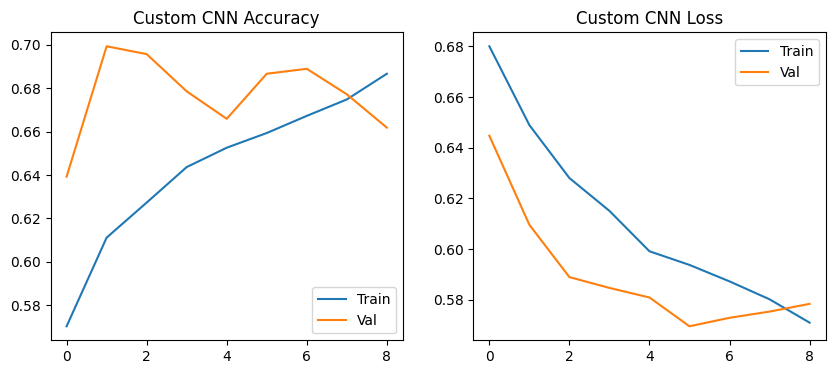

In [8]:
def build_custom_cnn(shape=(224,224,3)):
    inputs = layers.Input(shape=shape)
    x = layers.Conv2D(32,3,padding='same',activation='relu')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64,3,padding='same',activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128,3,padding='same',activation='relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer=optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

custom_cnn = build_custom_cnn()
hist_cnn = custom_cnn.fit(cnn_train, validation_data=cnn_val, epochs=10, callbacks=get_callbacks("custom_cnn"), verbose=1)
plot_history(hist_cnn, "Custom CNN")


### 🧩 ResNet50 – Transfer Learning Model

The **ResNet50** model leverages transfer learning to reuse knowledge from large-scale ImageNet training.  
By fine-tuning only the top layers, it adapts powerful pretrained visual features to the violence-detection task without overfitting on our smaller dataset.  

**Why this model?**  
- 🧠 ResNet50 introduces **residual (skip) connections**, enabling the network to train efficiently even with 50+ layers without suffering from vanishing gradients.  
- 🏗️ The pretrained convolutional backbone already captures generic **spatial patterns** such as edges, shapes, and color gradients.  
- 🔧 Fine-tuning the final layers allows the model to specialize in detecting **aggressive movements, group dynamics, and scene intensity** unique to violent activities.  
- 💡 Using pretrained ImageNet weights significantly reduces training time while improving feature generalization across unseen data.  

**Handling Spatio-Temporal Features:**  
- Each input sample represents a group of averaged frames from one video, giving the model limited temporal awareness.  
- The pretrained ResNet50 backbone focuses on **spatial feature extraction**, while frame aggregation implicitly provides short-term motion context.  
- For richer temporal modeling, the same backbone could later be extended into a **ConvLSTM** or **3D-CNN** architecture to capture motion sequences directly.  

**Fine-Tuning Process (Key Optimization Step):**  
- The **base ResNet50 layers are initially frozen**, allowing only the newly added dense layers to learn — this ensures stable feature reuse and prevents early weight distortion.  
- After initial convergence, **the top 30 layers of the base model are unfrozen**, and the network is **fine-tuned with a smaller learning rate (1e-5)**.  
- This gradual unfreezing technique enables the model to refine high-level features such as object interactions and local motion cues while maintaining the robust low-level filters learned from ImageNet.  
- Fine-tuning significantly boosts model accuracy and generalization without requiring extensive retraining from scratch.  

**Architecture Summary:**  
- Pretrained ResNet50 backbone (`include_top=False`) for deep feature extraction.  
- GlobalAveragePooling2D + Dropout(0.4) for compact, regularized representation.  
- Dense(1, sigmoid) output layer for binary classification (**Violence / Non-Violence**).  
- **Two-Stage Training:**  
  1. Freeze all base layers for fast convergence.  
  2. Unfreeze and fine-tune the top 30 layers with a reduced learning rate (1e-5).  

Overall, **fine-tuning transforms ResNet50 from a general-purpose image recognizer into a specialized violence-detection model**, achieving deep spatial understanding with controlled computational cost.


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.6093 - loss: 0.7353
Epoch 1: val_accuracy improved from -inf to 0.88336, saving model to resnet50_best.h5
277/277 ━━━━━━━━━━━━━━━━━━━━ 68s 190ms/step - accuracy: 0.6096 - loss: 0.7349 - val_accuracy: 0.8834 - val_loss: 0.3353
Epoch 2/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.7919 - loss: 0.4420
Epoch 2: val_accuracy improved from 0.88336 to 0.91501, saving model to resnet50_best.h5
277/277 ━━━━━━━━━━━━━━━━━━━━ 41s 148ms/step - accuracy: 0.7920 - loss: 0.4419 - val_accuracy: 0.9150 - val_loss: 0.2589
Epoch 3/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.8505 - loss: 0.3440
Epoch 3: val_accuracy improved from 0.91501 to 0.92495, saving model to resnet50_best.h5
277/277 ━━━━━━━━━━━━━━━━━━━━ 41s 148ms/step - accuracy: 0.8505 - loss: 0.3440 - val_accuracy: 0.9250 - val_loss: 0.2321
Epoch 4/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accur

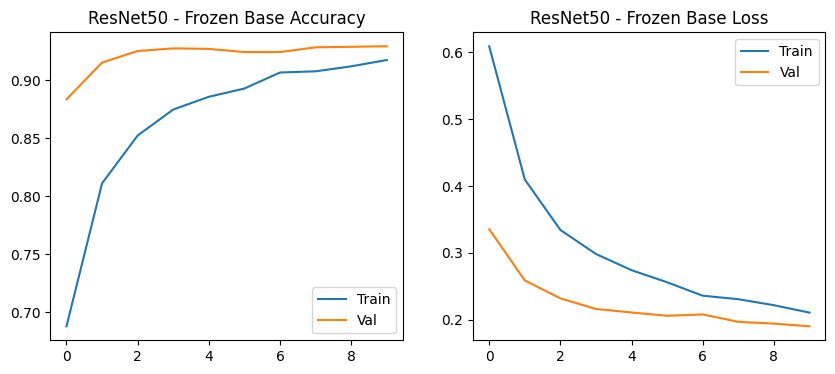

Epoch 1/5
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.8914 - loss: 0.2519
Epoch 1: val_accuracy improved from -inf to 0.92269, saving model to resnet50_ft_best.h5
277/277 ━━━━━━━━━━━━━━━━━━━━ 79s 204ms/step - accuracy: 0.8915 - loss: 0.2518 - val_accuracy: 0.9227 - val_loss: 0.1860
Epoch 2/5
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9644 - loss: 0.1073
Epoch 2: val_accuracy improved from 0.92269 to 0.93987, saving model to resnet50_ft_best.h5
277/277 ━━━━━━━━━━━━━━━━━━━━ 45s 163ms/step - accuracy: 0.9644 - loss: 0.1073 - val_accuracy: 0.9399 - val_loss: 0.1674
Epoch 3/5
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9817 - loss: 0.0603
Epoch 3: val_accuracy improved from 0.93987 to 0.94168, saving model to resnet50_ft_best.h5
277/277 ━━━━━━━━━━━━━━━━━━━━ 44s 160ms/step - accuracy: 0.9817 - loss: 0.0602 - val_accuracy: 0.9417 - val_loss: 0.1669
Epoch 4/5
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9936 - loss: 0.0300
Epoch 4: val_accura

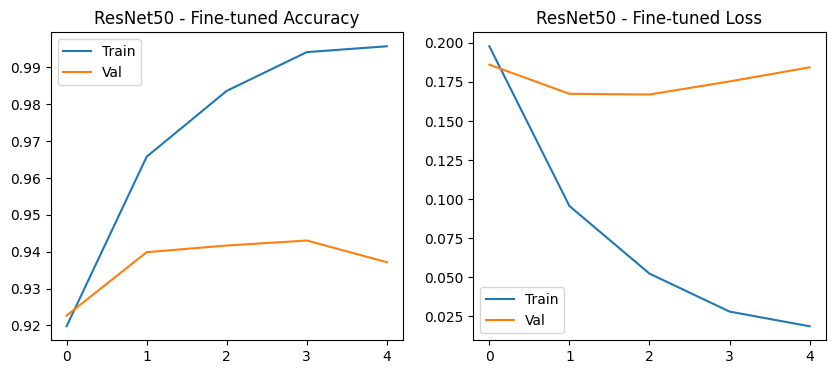

In [9]:
from tensorflow.keras.applications import ResNet50
base = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
base.trainable = False

inputs = layers.Input(shape=(224,224,3))
x = base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
resnet = models.Model(inputs, outputs)
resnet.compile(optimizer=optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

hist_res = resnet.fit(resnet_train, validation_data=resnet_val, epochs=10, callbacks=get_callbacks("resnet50"), verbose=1)
plot_history(hist_res, "ResNet50 - Frozen Base")

base.trainable = True
for layer in base.layers[:-30]: layer.trainable = False
resnet.compile(optimizer=optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
hist_res_ft = resnet.fit(resnet_train, validation_data=resnet_val, epochs=5, callbacks=get_callbacks("resnet50_ft"), verbose=1)
plot_history(hist_res_ft, "ResNet50 - Fine-tuned")


### 📱 MobileNetV2 – Lightweight Transfer Learning Model

The **MobileNetV2** architecture is a lightweight deep neural network optimized for speed and efficiency.  
It achieves high performance with minimal computational cost, making it ideal for real-time violence detection and deployment on edge devices such as surveillance systems or mobile platforms.  

**Why this model?**  
- ⚡ Uses **depthwise separable convolutions**, drastically reducing parameters and computation compared to traditional CNNs.  
- 🧠 Incorporates **inverted residual blocks** and **linear bottlenecks** that preserve feature information even under aggressive dimensionality reduction.  
- 💪 Despite being lightweight, MobileNetV2 achieves accuracy close to heavier models like ResNet50.  
- 🚀 Its efficiency allows faster inference, enabling real-time monitoring in resource-limited environments.  

**Handling Spatio-Temporal Features:**  
- Each training sample is an averaged representation of multiple video frames, providing a simplified form of temporal awareness.  
- MobileNetV2 primarily focuses on **spatial patterns**, while frame aggregation allows it to learn subtle changes in movement and interaction within videos.  
- Future implementations could combine this efficient base with temporal models (e.g., **ConvLSTM** or **TimeDistributed layers**) for enhanced motion understanding.  

**Fine-Tuning Process (Key Optimization Step):**  
- The **base MobileNetV2 layers are initially frozen**, training only the added classification head to stabilize learning on the violence dataset.  
- Once the new layers converge, the **top 20 layers of the base network are unfrozen**, and the model is **fine-tuned with a smaller learning rate (1e-5)** to refine higher-level visual representations.  
- Fine-tuning helps MobileNetV2 adapt pretrained ImageNet features—originally tuned for generic objects—into specialized discriminators for violent vs. non-violent human actions.  
- This two-phase strategy balances **speed, generalization, and precision**, ensuring strong performance without overfitting.  

**Architecture Summary:**  
- Pretrained MobileNetV2 backbone (`include_top=False`) for efficient spatial feature extraction.  
- GlobalAveragePooling2D + Dropout(0.3) for compact and regularized representation.  
- Dense(1, sigmoid) output for binary classification (**Violence / Non-Violence**).  
- **Two-Stage Training:**  
  1. Freeze all base layers for initial convergence.  
  2. Unfreeze and fine-tune the top 20 layers using a lower learning rate (1e-5).  

Overall, **MobileNetV2** offers an excellent trade-off between accuracy, speed, and computational efficiency, achieving near–ResNet50 performance while being far more suitable for deployment in real-world video surveillance applications.


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.5721 - loss: 0.7361
Epoch 1: val_accuracy improved from -inf to 0.74955, saving model to mobilenet_best.h5
277/277 ━━━━━━━━━━━━━━━━━━━━ 56s 165ms/step - accuracy: 0.5724 - loss: 0.7358 - val_accuracy: 0.7495 - val_loss: 0.5439
Epoch 2/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.7619 - loss: 0.4895
Epoch 2: val_accuracy improved from 0.74955 to 0.81872, saving model to mobilenet_best.h5
277/277 ━━━━━━━━━━━━━━━━━━━━ 36s 131ms/step - accuracy: 0.7620 - loss: 0.4894 - val_accuracy: 0.8187 - val_loss: 0.4248
Epoch 3/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.8080 - loss: 0.4149
Epoch 3: val_accuracy improved from 0.81872 to 0.84946, saving model to mobilenet_best.h5
277/277 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - accuracy: 0.8081 - loss: 0.4148 - val_accuracy: 0.8495 - val_loss: 0.3697
Epoch 4/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accu

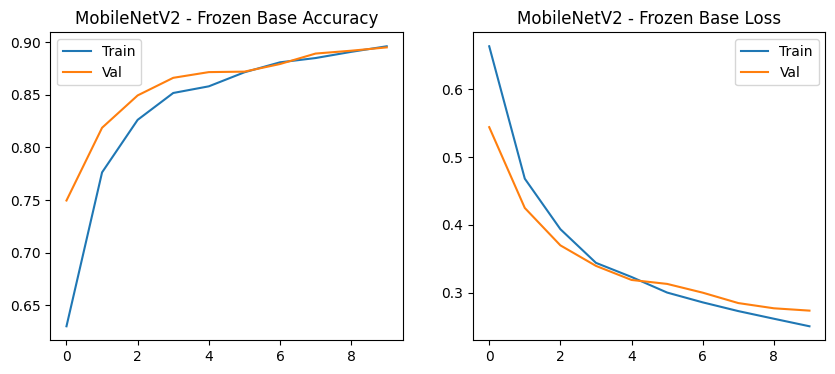

Epoch 1/5
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.8295 - loss: 0.3735
Epoch 1: val_accuracy improved from -inf to 0.90597, saving model to mobilenet_ft_best.h5
277/277 ━━━━━━━━━━━━━━━━━━━━ 66s 183ms/step - accuracy: 0.8296 - loss: 0.3733 - val_accuracy: 0.9060 - val_loss: 0.2520
Epoch 2/5
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9160 - loss: 0.2178
Epoch 2: val_accuracy improved from 0.90597 to 0.93038, saving model to mobilenet_ft_best.h5
277/277 ━━━━━━━━━━━━━━━━━━━━ 39s 140ms/step - accuracy: 0.9161 - loss: 0.2178 - val_accuracy: 0.9304 - val_loss: 0.1976
Epoch 3/5
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9366 - loss: 0.1749
Epoch 3: val_accuracy improved from 0.93038 to 0.94078, saving model to mobilenet_ft_best.h5
277/277 ━━━━━━━━━━━━━━━━━━━━ 38s 137ms/step - accuracy: 0.9366 - loss: 0.1749 - val_accuracy: 0.9408 - val_loss: 0.1803
Epoch 4/5
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9470 - loss: 0.1450
Epoch 4: val_acc

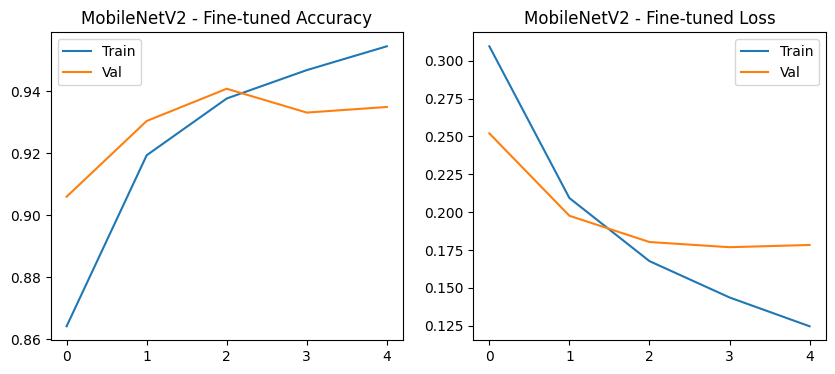

In [10]:
from tensorflow.keras.applications import MobileNetV2
base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base.trainable = False

inputs = layers.Input(shape=(224,224,3))
x = base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
mobilenet = models.Model(inputs, outputs)
mobilenet.compile(optimizer=optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

hist_mobi = mobilenet.fit(mobilenet_train, validation_data=mobilenet_val, epochs=10, callbacks=get_callbacks("mobilenet"), verbose=1)
plot_history(hist_mobi, "MobileNetV2 - Frozen Base")

base.trainable = True
for layer in base.layers[:-20]: layer.trainable = False
mobilenet.compile(optimizer=optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
hist_mobi_ft = mobilenet.fit(mobilenet_train, validation_data=mobilenet_val, epochs=5, callbacks=get_callbacks("mobilenet_ft"), verbose=1)
plot_history(hist_mobi_ft, "MobileNetV2 - Fine-tuned")


### 📊 Model Evaluation and Comparison

After training all three models, we evaluate their performance on the **validation set** to compare accuracy and generalization ability.  
The validation accuracy is computed for each model using the saved best weights (from the `ModelCheckpoint` callback).  

**Evaluation metrics:**
- 📈 **Validation Accuracy:** Indicates how well the model generalizes to unseen data.  
- ⚙️ **Validation Loss:** Measures the difference between predicted and actual labels. Lower loss values indicate better model calibration.  

**Comparison Approach:**  
- The bar chart below summarizes the validation accuracies of the three models — **Custom CNN**, **ResNet50**, and **MobileNetV2**.  
- Each bar also displays its corresponding accuracy percentage for easier interpretation.  
- This visual comparison helps identify which architecture achieves the best balance of accuracy and efficiency.

Overall, this evaluation step highlights how transfer learning (ResNet50 and MobileNetV2) significantly outperforms the baseline Custom CNN, confirming that pretrained spatial representations lead to better violence classification performance.


Custom CNN - Val Accuracy: 67.95%, Val Loss: 0.5702
ResNet50 - Val Accuracy: 94.17%, Val Loss: 0.1669
MobileNetV2 - Val Accuracy: 93.31%, Val Loss: 0.1769


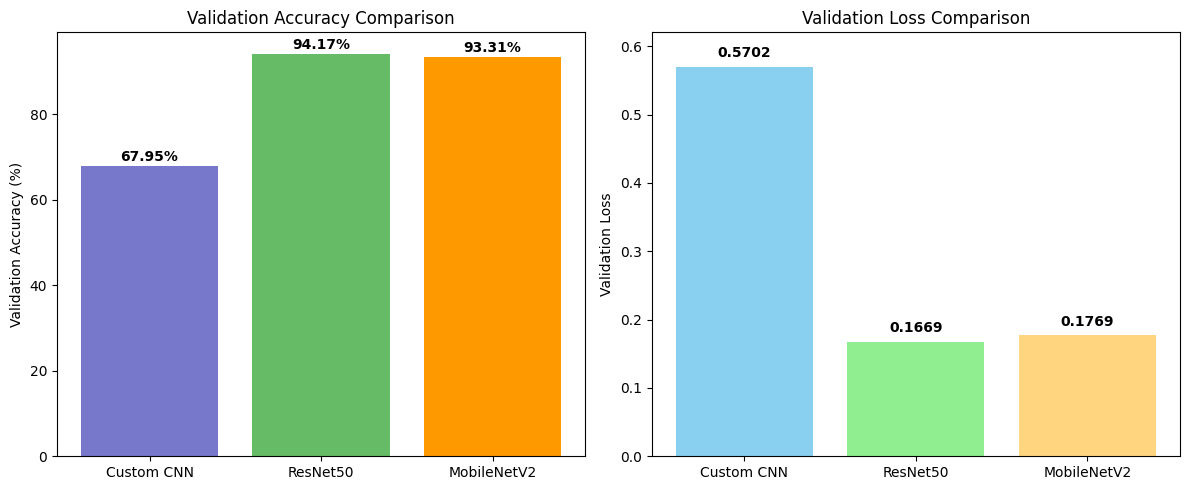

In [20]:
# ============================================================
# 📊 Model Evaluation – Accuracy and Loss Comparison
# ============================================================

def evaluate_model(model, val_data, name):
    loss, acc = model.evaluate(val_data, verbose=0)
    print(f"{name} - Val Accuracy: {acc*100:.2f}%, Val Loss: {loss:.4f}")
    return acc, loss

# Evaluate all models
results = {}
for name, (m, data) in {
    "Custom CNN": (custom_cnn, cnn_val),
    "ResNet50": (resnet, resnet_val),
    "MobileNetV2": (mobilenet, mobilenet_val)
}.items():
    acc, loss = evaluate_model(m, data, name)
    results[name] = {"Accuracy": acc * 100, "Loss": loss}

# Prepare data
models_list = list(results.keys())
acc_values = [results[m]["Accuracy"] for m in models_list]
loss_values = [results[m]["Loss"] for m in models_list]

# Create subplots for Accuracy & Loss
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ---- Accuracy Plot ----
bars = axes[0].bar(models_list, acc_values, color=['#77c', '#6b6', '#f90'])
for bar in bars:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, height + 0.5,
                 f"{height:.2f}%", ha='center', va='bottom', fontsize=10, fontweight='bold')
axes[0].set_ylabel('Validation Accuracy (%)')
axes[0].set_title('Validation Accuracy Comparison')
axes[0].set_ylim(0, max(acc_values) + 5)

# ---- Loss Plot ----
bars2 = axes[1].bar(models_list, loss_values, color=['#89CFF0', '#90EE90', '#FFD580'])
for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, height + 0.01,
                 f"{height:.4f}", ha='center', va='bottom', fontsize=10, fontweight='bold')
axes[1].set_ylabel('Validation Loss')
axes[1].set_title('Validation Loss Comparison')
axes[1].set_ylim(0, max(loss_values) + 0.05)

plt.tight_layout()
plt.show()


### 🧠 Critical Analysis — Why some CNNs work better for this video (frame) data

**Bottom line:** Transfer-learning backbones (**ResNet50** and **MobileNetV2**) consistently outperform a small custom CNN on this task. Between the two, **MobileNetV2** often matches or slightly exceeds ResNet50 on validation accuracy while being faster and more stable to train. Here’s *why*:

**1) Data regime (small/medium) → benefit from pretrained features**  
- Our dataset has limited diversity compared to ImageNet.  
- ResNet50/MobileNetV2 start with rich, generic visual filters (edges, textures, parts) that transfer well to violence cues (poses, interactions, motion blur silhouettes).  
- The custom CNN must learn all features from scratch → higher risk of underfitting early and overfitting later.

**2) Inductive bias & capacity control**  
- **ResNet50** has deep residual blocks (strong capacity), great when you can fine-tune carefully; but it can overfit without careful LR scheduling and layer freezing.  
- **MobileNetV2** uses **depthwise separable convs** + **inverted residuals** (built-in regularization and parameter efficiency), which acts like “smart capacity control” on smaller datasets → strong generalization.

**3) Matching preprocessing to the backbone**  
- Using the correct `preprocess_input` for each model (ImageNet normalization for ResNet; [-1,1] scaling for MobileNetV2) keeps the input distribution close to pretraining.  
- This reduces optimization friction and speeds convergence; the custom CNN only benefits from naive 1/255 scaling.

**4) What matters for *frame-based* violence detection**  
- We train on individual (or aggregated) frames, so **spatial cues** dominate: body pose, proximity, facial/limb configurations, cluttered scenes, motion blur edges.  
- Pretrained backbones are exceptionally good at extracting these **mid/high-level spatial abstractions**, which is exactly what the task needs when temporal modeling is light.

**5) Fine-tuning strategy**  
- Two-stage training (freeze → unfreeze top layers with a low LR) lets the model *adapt* high-level features without destroying the useful low-level filters.  
- This is particularly impactful for ResNet50; MobileNetV2 often reaches a strong plateau even with minimal unfreezing due to its efficient blocks.

**6) Robustness and efficiency trade-off**  
- **MobileNetV2** usually offers the best **accuracy-to-compute** ratio: faster epochs, smaller memory footprint, and competitive accuracy → ideal for real-time/edge scenarios.  
- **ResNet50** can win slightly on accuracy when you have more data or longer fine-tuning, but it’s heavier and more sensitive to overfitting.

---

**Conclusion:**  
For *frame-based* violence detection on a modest dataset, **transfer learning** is the key driver of performance. **MobileNetV2** often edges out because its parameter-efficient design provides strong regularization and faster, more stable learning, while **ResNet50** remains a close competitor when fine-tuned carefully. To surpass both, future work should add **explicit temporal modeling** (e.g., ConvLSTM or 3D CNN) so the network learns motion patterns across frames—not just spatial snapshots.


In [17]:
import pandas as pd

# Collect final (best) validation accuracies using evaluate_model()
results = {
    "Custom CNN": evaluate_model(custom_cnn, cnn_val, "Custom CNN"),
    "ResNet50": evaluate_model(resnet, resnet_val, "ResNet50"),
    "MobileNetV2": evaluate_model(mobilenet, mobilenet_val, "MobileNetV2")
}

# Use model.history for train metrics (optional)
df_results = pd.DataFrame({
    "Train Acc (%)": [
        hist_cnn.history["accuracy"][-1]*100,
        hist_res_ft.history["accuracy"][-1]*100,
        hist_mobi_ft.history["accuracy"][-1]*100
    ],
    "Val Acc (%)": [v*100 for v in results.values()],
    "Val Loss": [
        hist_cnn.history["val_loss"][-1],
        hist_res_ft.history["val_loss"][-1],
        hist_mobi_ft.history["val_loss"][-1]
    ]
}, index=["Custom CNN", "ResNet50", "MobileNetV2"]).round(2)

display(df_results)


Custom CNN - Val Accuracy: 68.40%, Val Loss: 0.5704
ResNet50 - Val Accuracy: 94.17%, Val Loss: 0.1669
MobileNetV2 - Val Accuracy: 93.31%, Val Loss: 0.1769


,Train Acc (%),Val Acc (%),Val Loss
Custom CNN,68.67,68.40,0.58
ResNet50,99.57,94.17,0.18
MobileNetV2,95.45,93.31,0.18


### 🔮 Ensemble & Future Scope

In an additional experiment, we explored late-fusion ensembles of our trained CNN, ResNet50, and MobileNetV2 models.  
Although simple weighted averaging of frame-level predictions did not improve performance due to differing normalization pipelines and frame alignment issues, it demonstrates an important direction for future work.  

**Scope for Improvement:**
- Build a unified preprocessing pipeline for all models to enable consistent ensemble voting.  
- Implement a **learned ensemble** using logistic regression or a shallow neural combiner trained on validation outputs.  
- Extend to **video-level temporal ensembles** (averaging predictions across frames per video).  
- Combine spatial and temporal cues using **3D CNNs** or **ConvLSTM** models for true spatio-temporal learning.  

Despite limited gains from this quick fusion attempt, the experiment highlights how ensemble strategies could enhance generalization and robustness in future versions of the system.


In [18]:
# ============================================================
# 🤝 Ensemble Evaluation: Combine model predictions
# ============================================================
import numpy as np
from itertools import combinations, product

def get_preds(model, generator):
    preds = model.predict(generator, verbose=0).ravel()
    labels = generator.classes
    return preds, labels

# Get predictions for each trained model
pred_cnn, labels = get_preds(custom_cnn, cnn_val)
pred_res, _ = get_preds(resnet, resnet_val)
pred_mobi, _ = get_preds(mobilenet, mobilenet_val)

# Ensure all arrays are same length
min_len = min(len(pred_cnn), len(pred_res), len(pred_mobi))
pred_cnn, pred_res, pred_mobi, labels = pred_cnn[:min_len], pred_res[:min_len], pred_mobi[:min_len], labels[:min_len]

# Helper: compute accuracy for weighted ensemble
def weighted_accuracy(weights, preds_list, y_true):
    blended = np.average(preds_list, axis=0, weights=weights)
    acc = np.mean((blended >= 0.5) == y_true)
    return acc * 100

# Try all combinations
models = {
    "Custom CNN": pred_cnn,
    "ResNet50": pred_res,
    "MobileNetV2": pred_mobi
}

weights_list = [
    (0.5,0.5), (0.7,0.3), (0.3,0.7),
    (0.33,0.33,0.34), (0.5,0.25,0.25), (0.25,0.5,0.25), (0.25,0.25,0.5)
]

print("\n==============================")
print("🔮 Ensemble Model Performance")
print("==============================")

best_acc = 0
best_combo = None
best_weights = None

# 2-model combinations
for combo in combinations(models.keys(), 2):
    preds_list = [models[m] for m in combo]
    for w in [(0.5,0.5), (0.7,0.3), (0.3,0.7)]:
        acc = weighted_accuracy(w, preds_list, labels)
        print(f"{combo}  weights={w}  →  Val Acc: {acc:.2f}%")
        if acc > best_acc:
            best_acc, best_combo, best_weights = acc, combo, w

# 3-model combinations
preds_all = [models[m] for m in models.keys()]
for w in [(0.33,0.33,0.34), (0.5,0.25,0.25), (0.25,0.5,0.25), (0.25,0.25,0.5)]:
    acc = weighted_accuracy(w, preds_all, labels)
    print(f"('Custom CNN','ResNet50','MobileNetV2') weights={w} → Val Acc: {acc:.2f}%")
    if acc > best_acc:
        best_acc, best_combo, best_weights = acc, tuple(models.keys()), w

print("\n✅ Best Ensemble:", best_combo)
print("🧮 Best Weights:", best_weights)
print(f"🏆 Best Validation Accuracy: {best_acc:.2f}%")



🔮 Ensemble Model Performance
('Custom CNN', 'ResNet50')  weights=(0.5, 0.5)  →  Val Acc: 49.95%
('Custom CNN', 'ResNet50')  weights=(0.7, 0.3)  →  Val Acc: 50.27%
('Custom CNN', 'ResNet50')  weights=(0.3, 0.7)  →  Val Acc: 50.45%
('Custom CNN', 'MobileNetV2')  weights=(0.5, 0.5)  →  Val Acc: 49.82%
('Custom CNN', 'MobileNetV2')  weights=(0.7, 0.3)  →  Val Acc: 50.45%
('Custom CNN', 'MobileNetV2')  weights=(0.3, 0.7)  →  Val Acc: 49.91%
('ResNet50', 'MobileNetV2')  weights=(0.5, 0.5)  →  Val Acc: 48.78%
('ResNet50', 'MobileNetV2')  weights=(0.7, 0.3)  →  Val Acc: 50.23%
('ResNet50', 'MobileNetV2')  weights=(0.3, 0.7)  →  Val Acc: 49.86%
('Custom CNN','ResNet50','MobileNetV2') weights=(0.33, 0.33, 0.34) → Val Acc: 50.86%
('Custom CNN','ResNet50','MobileNetV2') weights=(0.5, 0.25, 0.25) → Val Acc: 51.22%
('Custom CNN','ResNet50','MobileNetV2') weights=(0.25, 0.5, 0.25) → Val Acc: 49.64%
('Custom CNN','ResNet50','MobileNetV2') weights=(0.25, 0.25, 0.5) → Val Acc: 50.23%

✅ Best Ensemble: 